<p style="text-align:center">
    <a href="https://nbviewer.jupyter.org/github/twMr7/PyTorch-Deep-Learning/blob/master/02-Linear_Regression_with_PyTorch.ipynb">
        Open In Jupyter nbviewer
        <img style="float: center;" src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" width="120" />
    </a>
</p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/PyTorch-Deep-Learning/blob/master/02-Linear_Regression_with_PyTorch.ipynb)

# 2. Linear Regression with PyTorch

+ [**2.1 線性回歸**](#linear-regression)
    - [*MSE 損失函數*](#mse-loss)
    - [*R² 判定係數*](#r-square)
    - [*產生範例資料集*](#example-dataset)
    - [*使用 Scikit-Learn 的線性回歸模型*](#sklearn-linreg)
+ [**2.2 多項式回歸**](#polynomial-regression)
    - [*使用 Scikit-Learn 的多項式特徵轉換*](#sklearn-polylinreg)
    - [*計算 MSE 與 R²*](#calculate-mse-r2)
    - [*比較更高次特徵的擬合結果*](#higher-degree-comparison1)
+ [**2.3 類神經網路**](#neural-network)
    - [*類神經網路模型*](#nn-model)
    - [*類神經網路的學習方式*](#how-nn-learn)
+ [**2.4 類神經網路實作多項式回歸 － 使用 torch.Tensor**](#tensor-polyreg)
    - [*線性方程式與 MSE 損失函數的梯度解析解*](#analytic-gradient)
    - [*比較更高次特徵的擬合結果*](#higher-degree-comparison2)
+ [**2.5 利用 torch.autograd 實現**](#torch-autograd)
+ [**2.6 利用 PyTorch 的工具模組**](#pytorch-utils)
+ [**參考資料**](#references)


In [1]:
# 基本需求模組
import numpy as np
import matplotlib.pyplot as plt

# 輔助圖片顯示及嵌入 notebook
from IPython.display import Image

<a id="linear-regression"></a>

## 2.1 線性回歸

**線性回歸（Linear Regression）** 適用於擬合連續數值，現實生活中常見用來預測房價、氣溫、銷售額等問題。 線性回歸可以使用單層神經網路來實現，所需要用來實作的概念和技巧也適用於深度學習模型。

最簡單的線性回歸就是基於直線方程式，

$$
    y = f(x;\theta) = wx + b \tag{1}
$$

其中，$w$ 是斜率（slope），$b$ 是偏移量（offset），而 $\theta = (w,b)$ 是模型的所有參數。 經由調整 $\theta$，我們可以最小化殘差平方和（residual sum of squares），直到找到最小平方解為止（least square solution）。 當 $\mathbf{x} \in \mathbb{R}^{n}$ ，即輸入有 $n$ 個特徵時，$\mathbf{\theta} = (\mathbf{w}, b)$，稱之為**複回歸（Multiple Linear Regression）**。

$$
    f(\mathbf{x}; \mathbf{\theta}) = w_1 x_1 + w_2 x_2 + \dotsb + w_n x_n + b = \mathbf{w}^{\mathsf{T}}\mathbf{x} + b  \tag{2}
$$

當輸出 $\mathbf{y}$ 也是多個維度時，稱為 **multivariate linear regression**。

---
<a id="mse-loss"></a>

### § MSE 損失函數

既然回歸的輸出是連續數值，常用的損失函數是平方損失（quadratic loss）的形式 $ \mathscr{l}_2(y, \hat{y}) = (y - \hat{y})^2 $，使得比較大的殘差 $(y - \hat{y})$ 會被懲罰得比小殘差來得多。 針對模型預測品質的度量，我們通常會取所有樣本（設樣本數為 $m$）誤差的平均，稱為 [**mean squared error (MSE)**](https://en.wikipedia.org/wiki/Mean_squared_error)。

$$
\begin{align*}
    \mathbf{MSE}(\mathbf{\theta}) &= \frac{1}{m} \sum_{i=1}^{m} \left( y_i - \hat{y}_i \right)^{2}  \tag{3} \\
    &= \frac{1}{m} \sum_{i=1}^{m} \left( y_i - f(\mathbf{x}_i; \mathbf{\theta}) \right)^{2}  \tag{4}
\end{align*}
$$


---
<a id="r-square"></a>

### § R² 判定係數

在統計上，[**R² 判定係數**](https://en.wikipedia.org/wiki/Coefficient_of_determination)（coefficient of determination）可以用來判斷迴歸模型的解釋力，*is the proportion of the variance in the dependent variable that is predictable from the independent variable*。

$$
\begin{align*}
    RSS &= \sum_{i=1}^{m} \left( y_i - \hat{y}_i \right)^{2} \tag{5} \\
    TSS &= \sum_{i=1}^{m} \left( y_i - \bar{y} \right)^{2} \tag{6} \\
    \mathbf{R^2} &= 1 - \frac{RSS}{TSS}  \tag{7}
\end{align*}
$$

***RSS*** 是殘差平方和（*residual sum of squares*），而 ***TSS*** 是與樣本變異數成比例的總平方和（*total sum of squares*）。 所以 $\mathbf{R^2}$ 度量的是預測結果的變異相對於永遠預測平均值（$\hat{y}_i = \bar{y}$）的變異。 最佳的狀況下，預測值與實際值一致，則 $RSS=0$ 且 $\mathbf{R^2} = 1$，而永遠猜平均值的模型 $RSS=TSS$ 則是 $\mathbf{R^2} = 0$。


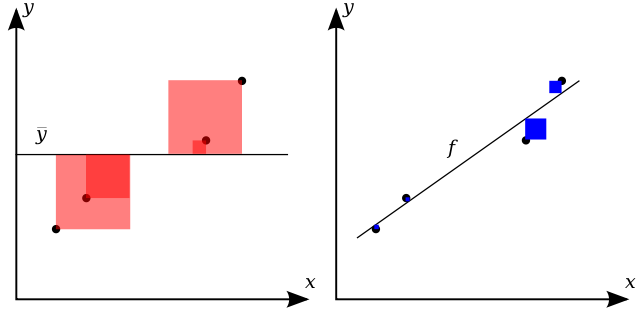

In [2]:
# 紅色 TSS，藍色 RSS
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Coefficient_of_Determination.svg/640px-Coefficient_of_Determination.svg.png', embed=True, width=640)

---
<a id="example-dataset"></a>

### § 產生範例資料集

使用事先設定的二次曲線 $y = -1.5x + \frac{1}{9}x^2 + \epsilon$ 加上些許雜訊，用來生成線性回歸用的訓練集和測試集。

**Note**: 以下程式碼改自參考書目 [[**1**]](#references) 書中範例，請參閱該書章節 1.2.2.1 及 1.2.2.2。

In [3]:
# 用二次曲線加雜訊生成範例資料點
def make_regression_xy(n=21):
    X_train = np.linspace(0.0, 20, n)
    X_test = np.arange(0.0, 20, 0.1)
    w = np.array([-1.5, 1/9.])
    quadratic = lambda x: w[0] * x + w[1] * np.square(x)

    np.random.seed(0)
    sigma = 2.0
    Y_train = quadratic(X_train) + np.random.normal(0, 1, X_train.shape) * sigma
    Y_test = quadratic(X_test) + np.random.normal(0, 1, X_test.shape) * sigma
    return X_train.reshape(-1,1), X_test.reshape(-1,1), Y_train, Y_test

In [4]:
# 生成線性回歸用的訓練集和測試集
X_train, X_test, Y_train, Y_test = make_regression_xy(n=21)

print(f'X train set shape = {X_train.shape}')
print(f'X test set shape = {X_test.shape}')
print(f'Y train set shape = {Y_train.shape}')
print(f'Y test set shape = {Y_test.shape}')

X train set shape = (21, 1)
X test set shape = (200, 1)
Y train set shape = (21,)
Y test set shape = (200,)


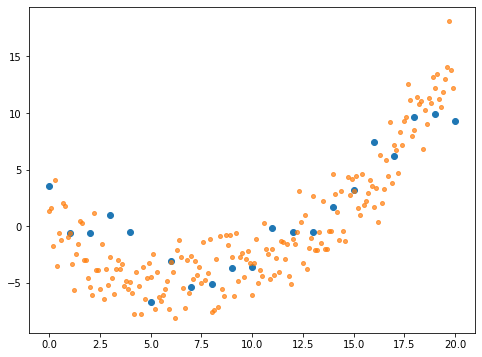

In [5]:
# 繪圖檢視資料集長的樣子
_, ax = plt.subplots(figsize=(8, 6))
ax.plot(X_train, Y_train, 'o')
ax.plot(X_test, Y_test, '.', markersize=8, alpha=0.7)
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler

# 調整資料集的尺度
mimxscaler = MinMaxScaler(feature_range=(-1, 1))
X_train = mimxscaler.fit_transform(X_train)
X_test = mimxscaler.transform(X_test)

<a id="sklearn-linreg"></a>

### § 使用 Scikit-Learn 的線性回歸模型

先使用 scikit-Learn 現成的線性回歸類別 [**`LinearRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) 來試試，還不急著計算 MSE 和 R²，因為可以預期簡單線性回歸的模型就是只有線性預測的能力。


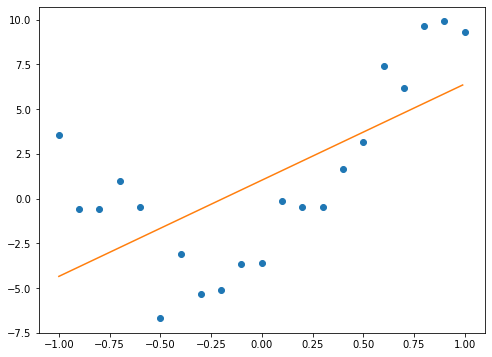

In [7]:
from sklearn.linear_model import LinearRegression

# 使用 sklearn 的線性回歸模型來擬合二次曲線資料點
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_predict = linreg.predict(X_test)

# 畫出預測點
_, ax = plt.subplots(figsize=(8, 6))
ax.plot(X_train, Y_train, 'o')
ax.plot(X_test, Y_predict)
plt.show()


<a id="polynomial-regression"></a>

## 2.2  多項式回歸

現實世界存在許多非線性的數據，但是線性回歸的模型能力顯然連二次曲線的資料點都擬合不好，要學來何用？ 先別急，稍後會解釋。 要解決用線性模型擬合二次曲線的問題，我們可以透過特徵工程的技巧將原特徵 $\mathbf{x}$ 做非線性的轉換，使得線性模型可以處理二次或更高次的多項式空間的數據，這個模型稱為**多項式回歸（polynomial regression）**。
$$
    f(\mathbf{x};\mathbf{w}) = \mathbf{w}^{\mathsf{T}} \phi(\mathbf{x}) \tag{8} \\
    \phi(\mathbf{x}) = [1, x, x^2, \dotsc, x^n] 
$$

轉換函數 $\phi(\mathbf{x})$ 不是限定如上式一種特定形式而已，還可以加入交叉項。 例如當輸入是兩個維度的特徵 $[x_1, x_2]$ 時，二次多項式特徵轉換可以是 $[1, x_1, x_2, x_1^2, x_{1}x_{2}, x_2^2]$。



#### 線性模型的良好特性

請注意，雖然上述的多項式回歸模型使用非線性函數將輸入 $\mathbf{x}$ 作轉換，預測函數仍然是用線性函數的參數 $\mathbf{w}$。 The reason this is important is that a linear model induces an $\mathbf{MSE}$ loss function $\mathbf{MSE}(\theta)$ that has a unique global optimum（參閱[[**1**]](#references)，章節 11.2.2.1）。


---
<a id="sklearn-polylinreg"></a>

### § 使用 Scikit-Learn 的多項式特徵轉換

多項式特徵轉換可以用 Scikit-Learn 現成的類別 [**`PolynomialFeatures`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)。 按照之前教過避免 Data Leakage 的原則，在訓練 LinearRegression 模型前先將輸入 X 做 **fit_transform()**，在預測前則是直接 **transform()** 做轉換。


In [8]:
# 還是先以 sklearn 做示範，使用現成的轉換工具 PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

class SkPolyLinearRegression:
    """Scikit-Learn version of Linear regression model with polynomial feature transform

    Parameters
    ----------
    n_degree : int　
    """
    def __init__(self, n_degree=2):
        self.polyfe = PolynomialFeatures(degree=n_degree, include_bias=False)
        self.linreg = LinearRegression()
    
    def fit(self, X, Y):
        """fit training data

        Parameters
        ----------
        X : input shape = (n_samples, n_features)
        Y : label shape = (n_samples,)
        """
        # transform input X to polynomial space
        X_poly = self.polyfe.fit_transform(X)
        self.linreg.fit(X_poly, Y)

    def predict(self, X):
        """Given X to predict Y_hat value

        Parameters
        ----------
        X : input shape = (n_samples, n_features)
        """
        X_poly = self.polyfe.transform(X)
        return self.linreg.predict(X_poly)


---
<a id="calculate-mse-r2"></a>

### § 計算 MSE 與 R²

可以嘗試自己計算 MSE 與 R²，這兩個指標的數學式用 numpy 來實現並不困難。 Scikit-Learn 也有提供相對應的函數 [**`mean_squared_error`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) 與 [**`r2_score`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)，可以比對一下自己寫的跟現成函數的計算結果。


In [9]:
# 練習自己動手寫 MSE 和 R²，可以跟註解裡使用 sklearn 部分的結果做比對

#from sklearn.metrics import mean_squared_error, r2_score

degree = 2
# train with sklean linear regression with feature transform
skpolylinreg = SkPolyLinearRegression(n_degree=degree)
skpolylinreg.fit(X_train, Y_train)

Y_predict_train = skpolylinreg.predict(X_train)
#mse_train = mean_squared_error(Y_train, Y_predict_train)
mse_train = np.square(Y_train - Y_predict_train).mean()

#r2_train = r2_score(Y_train, Y_predict_train)
RSS = np.square(Y_train - Y_predict_train).sum()
TSS = np.square(Y_train - Y_train.mean()).sum()
r2_train = 1 - (RSS / TSS)

Y_predict_test = skpolylinreg.predict(X_test)
#mse_test = mean_squared_error(Y_test, Y_predict_test)
mse_test = np.square(Y_test - Y_predict_test).mean()

#r2_test = r2_score(Y_test, Y_predict_test)
RSS = np.square(Y_test - Y_predict_test).sum()
TSS = np.square(Y_test - Y_test.mean()).sum()
r2_test = 1 - (RSS / TSS)

print(f'Train MSE = {mse_train:.3f}, R² = {r2_train:.3f}')
print(f'Test MSE = {mse_test:.3f}, R² = {r2_test:.3f}')


Train MSE = 3.140, R² = 0.871
Test MSE = 5.840, R² = 0.813


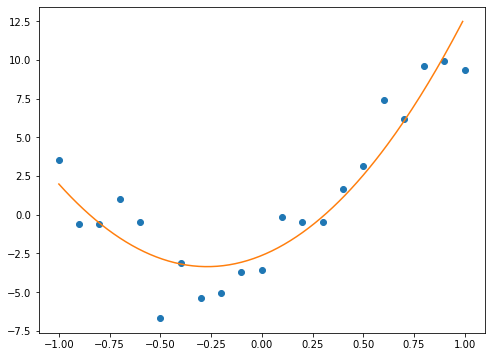

In [10]:
# 畫出預測點
_, ax = plt.subplots(figsize=(8, 6))
ax.plot(X_train, Y_train, 'o')
ax.plot(X_test, Y_predict_test)
plt.show()

---
<a id="higher-degree-comparison1"></a>

### § 比較更高次特徵的擬合結果

使用二次的多項式特徵，模型訓練的 MSE 結果似乎還可以有改進的空間。 我們可以嘗試增加三次項、四次項、...，直到訓練出完美擬合的 $\mathbf{MSE}=0$ 為止，但是這樣的結果是好的嗎？ 模型擬合的預測函數符合實際數據的模型嗎？


In [11]:
from sklearn.metrics import mean_squared_error, r2_score

# training with polynomial degrees 1..20
degrange = np.arange(1, 21, 1)
train_record = {'MSE': list(), 'R2': list(), 'Y_predict': list()}
test_record = {'MSE': list(), 'R2': list(), 'Y_predict': list()}

for degree in degrange:
    print('---- Degree #{} training ----'.format(degree))
    skpolylinreg = SkPolyLinearRegression(n_degree=degree)
    skpolylinreg.fit(X_train, Y_train)
    # training set
    Y_predict_train = skpolylinreg.predict(X_train)
    train_record['Y_predict'].append(Y_predict_train)
    mse_train = mean_squared_error(Y_train, Y_predict_train)
    train_record['MSE'].append(mse_train) 
    r2_train = r2_score(Y_train, Y_predict_train)
    train_record['R2'].append(r2_train) 
    print(f'>>>> train MSE = {mse_train:.3f}, R² = {r2_train:.3f}')
    # testing set
    Y_predict_test = skpolylinreg.predict(X_test)
    test_record['Y_predict'].append(Y_predict_test)
    mse_test = mean_squared_error(Y_test, Y_predict_test)
    test_record['MSE'].append(mse_test)
    r2_test = r2_score(Y_test, Y_predict_test)
    test_record['R2'].append(r2_test)
    print(f'>>>> test MSE = {mse_test:.3f}, R² = {r2_test:.3f}\n', flush=True)


---- Degree #1 training ----
>>>> train MSE = 13.802, R² = 0.434
>>>> test MSE = 16.454, R² = 0.473

---- Degree #2 training ----
>>>> train MSE = 3.140, R² = 0.871
>>>> test MSE = 5.840, R² = 0.813

---- Degree #3 training ----
>>>> train MSE = 2.286, R² = 0.906
>>>> test MSE = 6.209, R² = 0.801

---- Degree #4 training ----
>>>> train MSE = 1.889, R² = 0.923
>>>> test MSE = 7.013, R² = 0.776

---- Degree #5 training ----
>>>> train MSE = 1.888, R² = 0.923
>>>> test MSE = 6.972, R² = 0.777

---- Degree #6 training ----
>>>> train MSE = 1.874, R² = 0.923
>>>> test MSE = 6.898, R² = 0.779

---- Degree #7 training ----
>>>> train MSE = 1.633, R² = 0.933
>>>> test MSE = 6.832, R² = 0.781

---- Degree #8 training ----
>>>> train MSE = 1.259, R² = 0.948
>>>> test MSE = 7.560, R² = 0.758

---- Degree #9 training ----
>>>> train MSE = 1.193, R² = 0.951
>>>> test MSE = 7.430, R² = 0.762

---- Degree #10 training ----
>>>> train MSE = 1.190, R² = 0.951
>>>> test MSE = 7.421, R² = 0.763

---- De

In [13]:
# 畫出各項次特徵訓練結果的 MSE
def plot_mse_vs_degree(degrees, train_record, test_record):
    mse_train = np.array(train_record['MSE'])
    mse_test = np.array(test_record['MSE'])
    _, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
    # degree above 15 is known to not scale well on plot
    mask = degrees <= 15
    ax.plot(degrees[mask], mse_train[mask], marker='s', label='train')
    ax.plot(degrees[mask], mse_test[mask], marker='x', label='test')
    ax.set_xticks(degrees[mask])
    ax.set_xlabel('degree', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    ax.legend(loc='upper right', shadow=True, fontsize=12)
    plt.show()


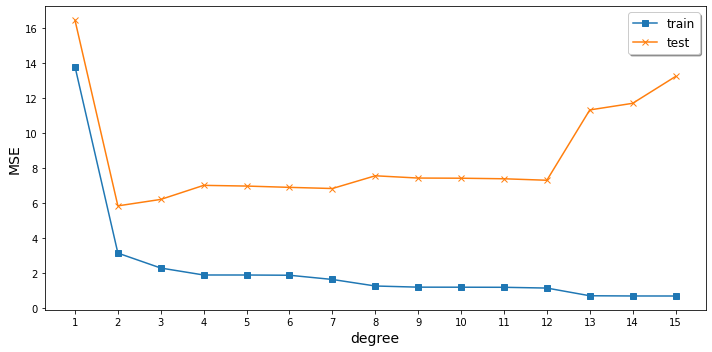

In [14]:
plot_mse_vs_degree(degrange, train_record, test_record)

In [20]:
# 畫出訓練結果的預測函數模型
def plot_fitted_function(X, Y, Xtest, test_record):
    degrees = [1, 2, 14, 20]
    _, axs = plt.subplots(2, 2, figsize=(10, 9), tight_layout=True)
    for ax, degree in zip(axs.reshape(-1), degrees):
        ax.plot(X, Y, 'o')
        ax.plot(Xtest, test_record['Y_predict'][degree-1])
        ax.set_ylim((-10, 15))
        mse = test_record['MSE'][degree-1]
        r2 = test_record['R2'][degree-1]
        ax.set_title(f'degree {degree}: MSE={mse:.3f}, R²={r2:.3f}', fontsize=12)
    plt.show()


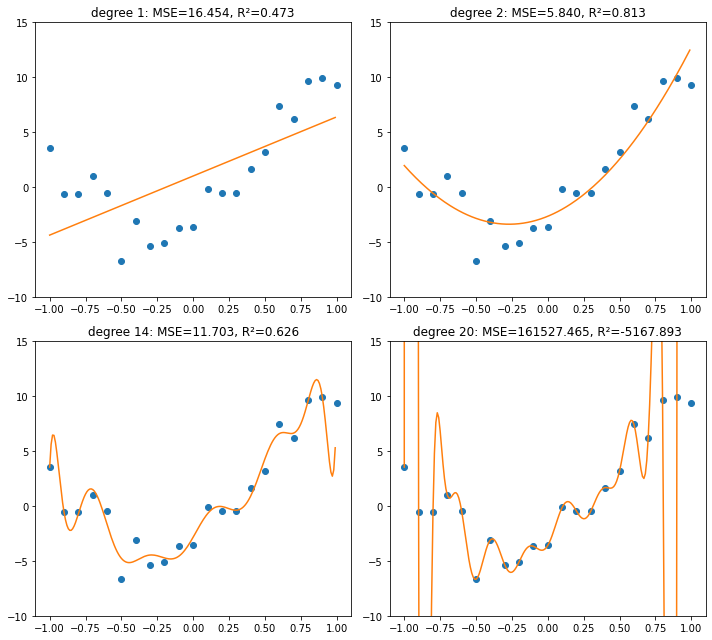

In [21]:
plot_fitted_function(X_train, Y_train, X_test, test_record)

<a id="neural-network"></a>

## 2.3 類神經網路


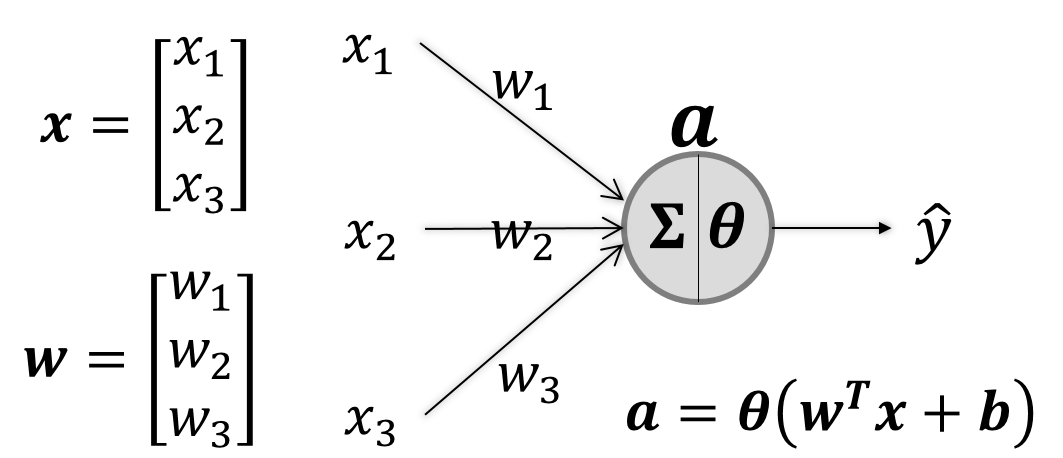

In [2]:
Image(filename='images/nn_single_neuron.png', width=480)

<a id="nn-model"></a>

### § 類神經網路模型

**類神經網路（Artificial Neural Network, ANN）** 的模型是模擬人類大腦神經連接運作的方式。 如上圖所示，單一神經元 $a$ 接收了三個訊號的輸入 $\mathbf{x} = [x_{1}, x_{2}, x_{3}]^{\mathsf{T}}$ 。 這三個訊號可能分別來自其他神經元的輸出，兩個神經元間若有突觸（synapse）相連接，訊號就會透過突觸傳導。 每個突觸對訊號的刺激會有強弱不同的反應（權重，weight）$\mathbf{w} =  [w_{1}, w_{2}, w_{3}]^{\mathsf{T}}$，個別訊號經過突觸的反應（與權重相乘）後在神經元匯集（加總，$\Sigma$），不同類型的神經元對訊號也會有不同的反應模式，通過神經元的反應會激發（**activation function**，$\theta$）一個對應的輸出 $a$。

整個網路若是由單一神經元構成，則輸出就直接是預測值 $\hat{y}$，數學模型可以寫成式 $(9)$，其中的權重 $\mathbf{w}$ 就是類神經網路模型要學習調整來擬合實際 $y$ 的參數，與輸入向量 $\mathbf{x}$ 內積的線性運算後，由 $\theta$ 函數激發反應（通常是非線性的，如 sigmoid 函數）。

$$
    \hat{y} = \theta(\mathbf{w}^{\mathsf{T}}\mathbf{x}) \tag{9}
$$

為了避免輸入訊號都為 0 時就無法順利學習，模型中加入了一個不為零的偏移值（bias）參數來解決這個問題，於是模型如式 $(10)$。 不過有時會看到 bias 項被當作權重 $\mathbf{w}$ 中永遠接受輸入為 1 的 $w_0$ 項，於是模型仍然簡化成如式 $(9)$ 的模型。

$$
    \hat{y} = \theta(\mathbf{w}^{\mathsf{T}}\mathbf{x} + b) \tag{10}
$$

現代類神經網路常會將多個神經元節點組成一個 layer，稱為隱藏層（hidden layer），然後在輸入和輸出之間配置一個或多個神經元節點相互連接的隱藏層，形成 [**多層感知器（Multilayer Perceptron, MLP）**](https://en.wikipedia.org/wiki/Multilayer_perceptron)。 如下的三層 MLP 示意圖，每一層裡神經元的上標標示了隱藏層的序號。 這是典型的全連結（fully-connected）網路形式，第一層有四個神經元節點，接受 $m$ 筆樣本輸入、每筆有四個特徵的 $m \times 4$ 大小的資料。 第一層的四個神經元分別各有三條突觸連結到第二層的三個神經元，而第二層的三個神經元又分別有一條突觸連結下一層神經元，最後每個樣本輸出一個運算結果組成向量 $\hat{Y}$。

針對多層的 MLP 類神經網路，以 $\mathbf{W}$ 代表所有權重向量 $\mathbf{w}$ 組成的陣列，$\mathbf{A}$ 代表一個層裡所有神經元激發的輸出向量，$\mathbf{Z}$ 是線性運算的部分, $\Theta$ 為 activation 函數，以上標 $[\mathsf{L}]$ 代表第 $L$ 層，則模型可以表示成：

$$
\begin{align*}
    \mathbf{Z}^{[\mathsf{L}]} &= \mathbf{W}^{[\mathsf{L}]} \mathbf{A}^{[\mathsf{L}-1]} + b^{[\mathsf{L}]} \tag{11} \\
    \mathbf{A}^{[\mathsf{L}]} &= \mathbf{\Theta}^{[\mathsf{L}]} \left( \mathbf{Z}^{[\mathsf{L}]} \right) \tag{12}
\end{align*}
$$


**【提醒】：**
在設計類神經網路架構，或是按照某個經典架構的藍圖寫程式碼時，首先要注意的就是每一個 layer 有幾個輸入？ 幾個輸出？ 輸出的個數要與下一層接受的輸入個數一致。


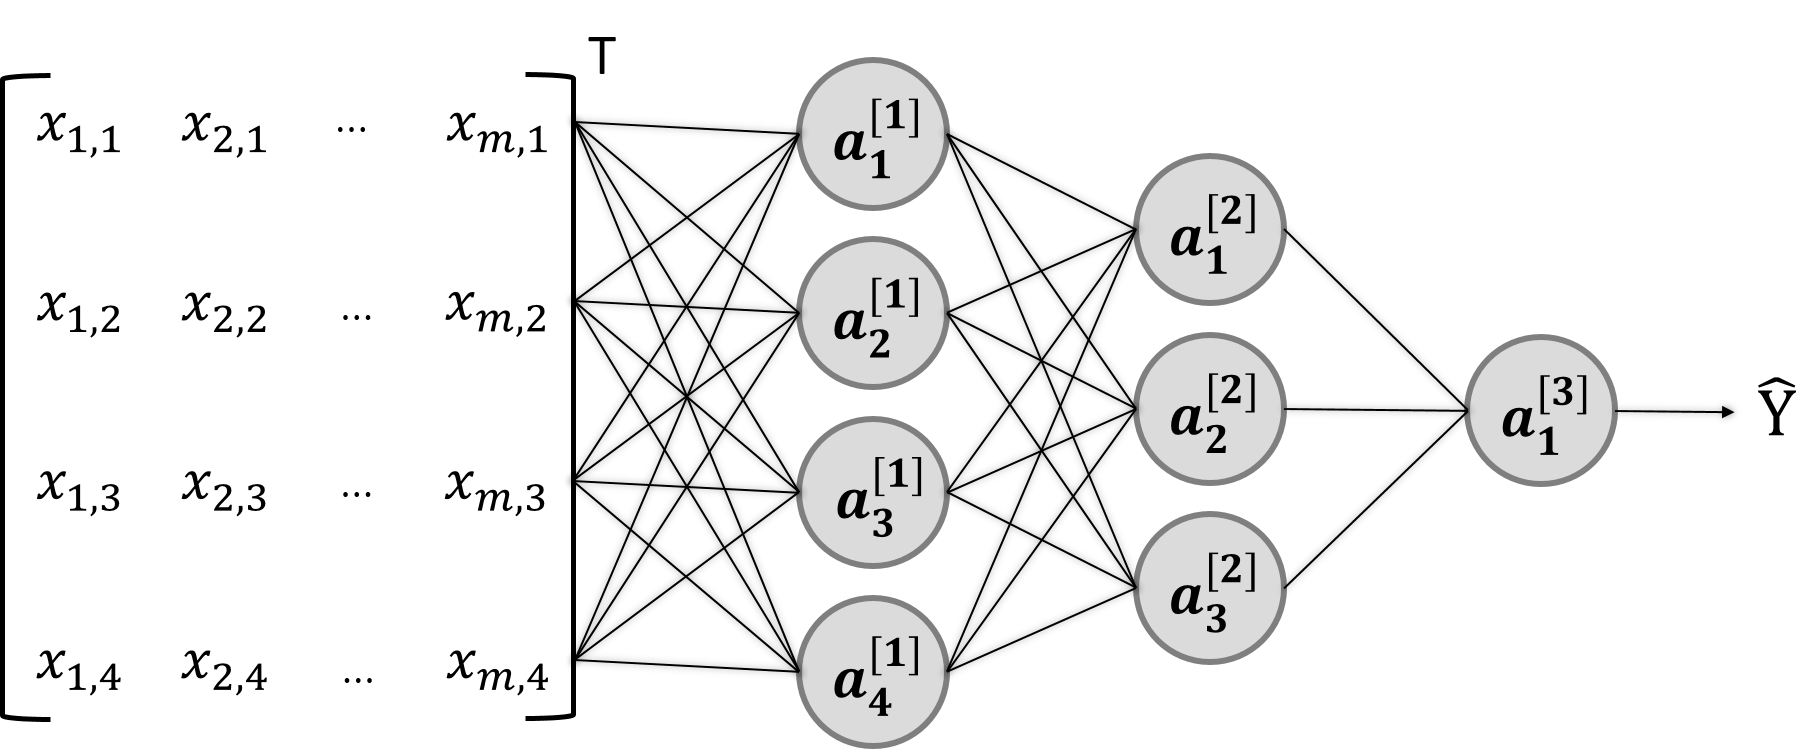

In [2]:
Image(filename='images/nn_mlp.png', width=800)

<a id="how-nn-learn"></a>

### § 類神經網路的學習方式

上述的模型，輸入訊號（可以是多個樣本同時輸入）與權重內積後經過 activation 函數輸出，然後通過每一層在最後一層輸出預測值 $\hat{Y}$（多個樣本的輸出），這在類神經網路學習模式下稱為前向傳導（**forward propagation**）。

針對學習的成果我們會先訂定一個目標函數（objective function），通常目標函數就是計算預測的 $\hat{y}$ 與目標 $y$ 的某種誤差評估指標，稱為損失函數（**loss function**）$\mathcal{L}(\hat{y}, y)$，將多個樣本的損失取平均稱為成本函數（**cost function**）$ J(\mathbf{w}, b)$。 假設共有 $m$ 筆樣本數據，目標向量 $Y = [y_1, y_2, \dots, y_m]$，前向傳導的輸出 $\hat{Y} = [\hat{y_{1}}, \hat{y_{2}}, \dots, \hat{y_{m}}]$，則成本函數可表示為式 $(13)$。

$$
    J(\mathbf{W}, b) = \frac{1}{m} \sum_{i=1}^{m} \mathcal{L}(\hat{y}_{i}, y_{i}) \tag{13}
$$

ANN 模型的訓練過程就是要最小化這個誤差的成本來學習最佳的權重 $\mathbf{W}$，最佳化的策略通常就是採取梯度下降（**gradient descent**）演算法，透過 chain rule 一層一層反向計算梯度，由損失函數的梯度開始，往回逐層計算梯度並更新權重，直到第一層為止。 透過這個往回逐層更新權重參數來縮小成本誤差的方式，稱為反向傳導（**back propagation**）。

梯度下降法是迭代方式的參數優化演算法，基本概念就像緩步下山，每一次迭代 $t$ 就像往山下的方向踏出一步，踏出的步伐大小由學習率（learning rate, $\eta$）這個超參數控制，每一步要走的方向則由梯度來決定，要下山是取梯度的反方向走，直到到達區域或全域的最低山谷點為止。

$$
    \mathbf{W}_{t+1} = \mathbf{W}_t - \eta \nabla J \left( \mathbf{W}_t, b \right) \tag{14}
$$

使用 gradient descent 最佳化 ANN 模型學習的迭代演算步驟如下：
1. 初始化權重參數 $\mathbf{W}$ 與 $b$。
2. (Forward) 接受輸入前向傳導。
3. 計算成本（損失）函數 $J(\mathbf{W}, b)$。
4. 計算梯度 $\nabla J(\mathbf{W}, b)$。
5. (Backward) 反向傳導更新參數。
6. 重複步驟2-5，直到損失收斂到最小，或達到事先設定的迭代次數。


<a id="tensor-polyreg"></a>

## 2.4 類神經網路實作多項式回歸 － 使用 torch.Tensor

ANN 使用單一神經元加上 $y = x$ 的線性 activation 函數，最後使用 MSE 函數估計 loss，這樣就建構了一個簡單線性回歸的模型了。 這個範例中暫時只使用基本的函數功能從頭實現，梯度要自己先算出解析解。


<a id="analytic-gradient"></a>

### § 線性方程式與 MSE 損失函數的梯度解析解

成本函數使用 MSE loss 的定義式為

$$
     J(\mathbf{W}, b) = \mathbf{MSE}(\mathbf{W}, b) = \frac{1}{m} \sum_{i=1}^{m} \left( Y_i - \hat{Y}_i \right)^{2}
$$

其中 $Y$ 是 constant，$\hat{Y} = \mathbf{W}X + b$，令 $u = \mathbf{W}X + b$，則

$$
\begin{align*}
    \frac{\partial J}{\partial \mathbf{W}} &= \frac{\partial J}{\partial u} \frac{\partial u}{\partial \mathbf{W}} \tag{15} \\
    \frac{\partial J}{\partial b} &= \frac{\partial J}{\partial u} \frac{\partial u}{\partial b} \tag{16} \\
    \frac{\partial J}{\partial u} &= \frac{2}{m} (Y_i - \hat{Y}_i) \tag{17} \\
    \frac{\partial u}{\partial \mathbf{W}} &= X \tag{18} \\
    \frac{\partial u}{\partial b} &= 1 \tag{19}
\end{align*}
$$

In [24]:
import torch
from sklearn.preprocessing import PolynomialFeatures

# to work with numpy's default float64
torch.set_default_tensor_type(torch.DoubleTensor)

class PolyLinearRegression:
    """Linear regression model with polynomial feature transform

    Parameters
    ----------
    learning_rate : float
    n_iteration : int
    n_degree : int　
    """
    def __init__(self, learning_rate=0.5, n_iteration=3000, n_degree=2):
        self.eta = learning_rate
        self.n_iter = n_iteration
        self.polynfe = PolynomialFeatures(degree=n_degree, include_bias=False)
    
    def initialize(self, n_features):
        """Initialize parameters: weight and bias
        """
        self.W = torch.normal(mean=0.0, std=0.01, size=(n_features,1))
        self.b = torch.normal(mean=0.0, std=0.01, size=(1,))

    def forward(self, X):
        """simple linear model

        Parameters
        ----------
        X : shape = (n_samples, n_features)
        """
        return torch.matmul(X, self.W) + self.b
    
    def mse_loss(self, Y, Y_hat):
        """Mean Square Error (MSE)
        """
        return torch.square(Y.view(Y_hat.size()) - Y_hat).mean()

    def gradient_func(self, X, Y, Y_hat):
        """apply chain rule for gradient
        u = Wx + b
        ∂J/∂W = (∂J/∂u)(∂u/∂W)
        ∂J/∂b = (∂J/∂u)(∂u/∂b)
        """
        dJ_du = 2 * (Y.view(Y_hat.size()) - Y_hat) / Y_hat.size()[0]
        dJ_dW = dJ_du * X
        dJ_db = dJ_du * 1.0
        return {'dW': dJ_dW.sum(dim=0).view(-1,1), 'db': dJ_db.sum()}

    def fit(self, X, Y):
        """fit training data

        Parameters
        ----------
        X : input shape = (n_samples, n_features)
        Y : label shape = (n_samples,)
        """
        # transform input X to polynomial space
        X_polyn = torch.tensor(self.polynfe.fit_transform(X))
        # convert Y to torch.Tensor
        Y = torch.from_numpy(Y)
        # using new polynomial feature for all the following procedure
        self.initialize(X_polyn.shape[1])
        for i in range(1, self.n_iter+1):
            Y_hat = self.forward(X_polyn)
            loss = self.mse_loss(Y, Y_hat)
            grads = self.gradient_func(X_polyn, Y, Y_hat)
            # update parameters
            self.W -= self.eta * grads['dW']
            self.b -= self.eta * grads['db']
            # print training info
            if i % 100 == 0:
                print(f'iter #{i}: loss = {loss:.3f}', flush=True)

    def predict(self, X):
        """Given X to predict Y_hat value

        Parameters
        ----------
        X : input shape = (n_samples, n_features)
        """
        X_polyn = torch.tensor(self.polynfe.transform(X))
        return torch.matmul(X_polyn, self.W) + self.b


In [25]:
from sklearn.metrics import mean_squared_error, r2_score

degree = 2
# train with polynomial linear regression
polylinreg = PolyLinearRegression(learning_rate=0.5, n_iteration=2000, n_degree=degree)
polylinreg.fit(X_train, Y_train)

# test
Y_predict_test = polylinreg.predict(X_test).numpy().squeeze()
mse_test = mean_squared_error(Y_test, Y_predict_test)
r2_test = r2_score(Y_test, Y_predict_test)
print(f'Test MSE = {mse_test:.3f}, R² = {r2_test:.3f}')


iter #100: loss = 3.140
iter #200: loss = 3.140
iter #300: loss = 3.140
iter #400: loss = 3.140
iter #500: loss = 3.140
iter #600: loss = 3.140
iter #700: loss = 3.140
iter #800: loss = 3.140
iter #900: loss = 3.140
iter #1000: loss = 3.140
iter #1100: loss = 3.140
iter #1200: loss = 3.140
iter #1300: loss = 3.140
iter #1400: loss = 3.140
iter #1500: loss = 3.140
iter #1600: loss = 3.140
iter #1700: loss = 3.140
iter #1800: loss = 3.140
iter #1900: loss = 3.140
iter #2000: loss = 3.140
Test MSE = 5.840, R² = 0.813


---
<a id="higher-degree-comparison2"></a>

### 比較更高次特徵的擬合結果


In [26]:
from sklearn.metrics import mean_squared_error, r2_score

def train_ndegree_polylin(degrange, polylinmodel, lr, n_iter, Xtrain, Xtest, Ytrain, Ytest):
    train_record = {'MSE': list(), 'R2': list(), 'Y_predict': list()}
    test_record = {'MSE': list(), 'R2': list(), 'Y_predict': list()}
    for degree in degrange:
        print(f'---- Degree #{degree} training ----')
        polylinreg = polylinmodel(learning_rate=lr, n_iteration=n_iter, n_degree=degree)
        polylinreg.fit(Xtrain, Ytrain)
        # training set
        Y_predict_train = polylinreg.predict(Xtrain).numpy().squeeze()
        train_record['Y_predict'].append(Y_predict_train)
        mse_train = mean_squared_error(Ytrain, Y_predict_train)
        train_record['MSE'].append(mse_train) 
        r2_train = r2_score(Ytrain, Y_predict_train)
        train_record['R2'].append(r2_train) 
        print(f'>>>> train MSE = {mse_train:.3f}, R² = {r2_train:.3f}')
        # testing set
        Y_predict_test = polylinreg.predict(Xtest).numpy().squeeze()
        test_record['Y_predict'].append(Y_predict_test)
        mse_test = mean_squared_error(Ytest, Y_predict_test)
        test_record['MSE'].append(mse_test)
        r2_test = r2_score(Ytest, Y_predict_test)
        test_record['R2'].append(r2_test)
        print(f'>>>> test MSE = {mse_test:.3f}, R² = {r2_test:.3f}\n', flush=True)
    return train_record, test_record


In [27]:
degrees = np.arange(1, 21, 1)

train_record, test_record = train_ndegree_polylin(
    degrees, PolyLinearRegression, 0.5, 2000,
    X_train, X_test, Y_train, Y_test)

---- Degree #1 training ----
iter #100: loss = 13.802
iter #200: loss = 13.802
iter #300: loss = 13.802
iter #400: loss = 13.802
iter #500: loss = 13.802
iter #600: loss = 13.802
iter #700: loss = 13.802
iter #800: loss = 13.802
iter #900: loss = 13.802
iter #1000: loss = 13.802
iter #1100: loss = 13.802
iter #1200: loss = 13.802
iter #1300: loss = 13.802
iter #1400: loss = 13.802
iter #1500: loss = 13.802
iter #1600: loss = 13.802
iter #1700: loss = 13.802
iter #1800: loss = 13.802
iter #1900: loss = 13.802
iter #2000: loss = 13.802
>>>> train MSE = 13.802, R² = 0.434
>>>> test MSE = 16.454, R² = 0.473

---- Degree #2 training ----
iter #100: loss = 3.140
iter #200: loss = 3.140
iter #300: loss = 3.140
iter #400: loss = 3.140
iter #500: loss = 3.140
iter #600: loss = 3.140
iter #700: loss = 3.140
iter #800: loss = 3.140
iter #900: loss = 3.140
iter #1000: loss = 3.140
iter #1100: loss = 3.140
iter #1200: loss = 3.140
iter #1300: loss = 3.140
iter #1400: loss = 3.140
iter #1500: loss =

>>>> train MSE = 1.539, R² = 0.937
>>>> test MSE = 6.847, R² = 0.781

---- Degree #15 training ----
iter #100: loss = 2.112
iter #200: loss = 1.967
iter #300: loss = 1.873
iter #400: loss = 1.805
iter #500: loss = 1.753
iter #600: loss = 1.712
iter #700: loss = 1.679
iter #800: loss = 1.653
iter #900: loss = 1.630
iter #1000: loss = 1.611
iter #1100: loss = 1.594
iter #1200: loss = 1.579
iter #1300: loss = 1.566
iter #1400: loss = 1.554
iter #1500: loss = 1.542
iter #1600: loss = 1.532
iter #1700: loss = 1.523
iter #1800: loss = 1.514
iter #1900: loss = 1.506
iter #2000: loss = 1.499
>>>> train MSE = 1.499, R² = 0.939
>>>> test MSE = 6.822, R² = 0.782

---- Degree #16 training ----
iter #100: loss = 2.137
iter #200: loss = 1.951
iter #300: loss = 1.839
iter #400: loss = 1.764
iter #500: loss = 1.711
iter #600: loss = 1.672
iter #700: loss = 1.642
iter #800: loss = 1.617
iter #900: loss = 1.597
iter #1000: loss = 1.579
iter #1100: loss = 1.563
iter #1200: loss = 1.549
iter #1300: loss =

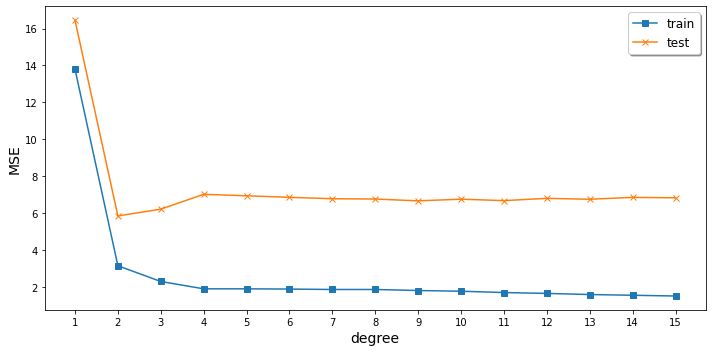

In [28]:
# 畫出各項次特徵訓練結果的 MSE
plot_mse_vs_degree(degrees, train_record, test_record)

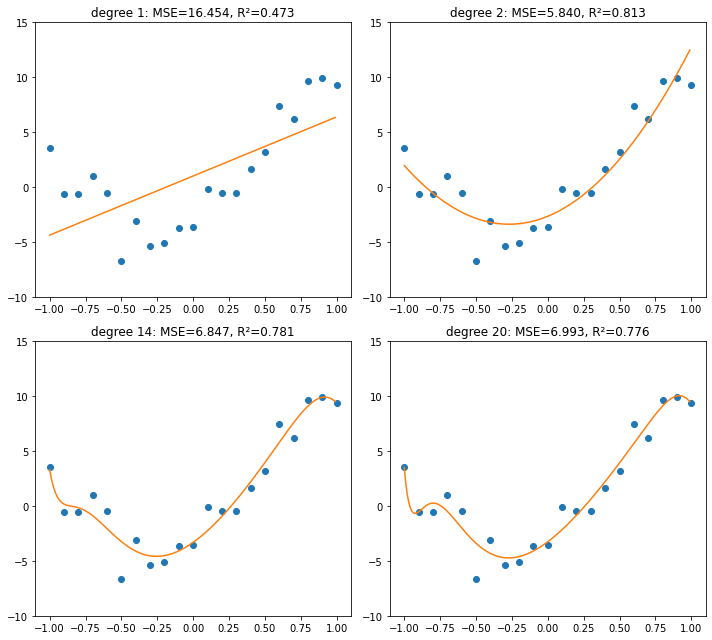

In [29]:
# 畫出訓練結果的預測函數模型
plot_fitted_function(X_train, Y_train, X_test, test_record)

<a id="torch-autograd"></a>

## 2.5 利用 torch.autograd 實現

**TODO**:
1. 什麼是 Autograd？
2. 怎麼用 Autograd？


In [30]:
from sklearn.preprocessing import PolynomialFeatures

class PolyAgLinearRegression:
    """Linear regression model with polynomial feature transform and autograd

    Parameters
    ----------
    learning_rate : float
    n_iteration : int
    n_degree : int　
    """
    def __init__(self, learning_rate=0.5, n_iteration=3000, n_degree=2):
        self.eta = learning_rate
        self.n_iter = n_iteration
        self.polynfe = PolynomialFeatures(degree=n_degree, include_bias=False)
    
    def initialize(self, n_features):
        """Initialize parameters: weight and bias
        Note that requires_grads are turned on
        """
        self.W = torch.normal(mean=0.0, std=0.01, size=(n_features,1), requires_grad=True)
        self.b = torch.normal(mean=0.0, std=0.01, size=(1,), requires_grad=True)

    def zero_grad(self):
        """zero out grads in parameters.
        Note: backward will accumulate derivatives,
              make sure to use a clean one before calling forward.
        """
        if self.W.grad is not None:
            self.W.grad.zero_()
        if self.b.grad is not None:
            self.b.grad.zero_()

    def forward(self, X):
        """simple linear model

        Parameters
        ----------
        X : shape = (n_samples, n_features)
        """
        return torch.matmul(X, self.W) + self.b
    
    def mse_loss(self, Y, Y_hat):
        """Mean Square Error (MSE)
        """
        return torch.square(Y_hat - Y.view(Y_hat.size())).mean()

    def fit(self, X, Y):
        """fit training data

        Parameters
        ----------
        X : input shape = (n_samples, n_features)
        Y : label shape = (n_samples,)
        """
        # transform input X to polynomial space
        X_polyn = torch.tensor(self.polynfe.fit_transform(X))
        # convert Y to torch.Tensor
        Y = torch.from_numpy(Y)
        # using new polynomial feature for all the following procedure
        self.initialize(X_polyn.shape[1])
        for i in range(1, self.n_iter+1):
            self.zero_grad()
            loss = self.mse_loss(Y, self.forward(X_polyn))
            loss.backward()
            # update parameters
            with torch.no_grad():
                self.W -= self.eta * self.W.grad
                self.b -= self.eta * self.b.grad
            # print training info
            if i % 100 == 0:
                print(f'iter #{i}: loss = {loss:.3f}', flush=True)

    def predict(self, X):
        """Given X to predict Y_hat value

        Parameters
        ----------
        X : input shape = (n_samples, n_features)
        """
        X_polyn = torch.tensor(self.polynfe.transform(X))
        with torch.no_grad():
            Y_hat = torch.matmul(X_polyn, self.W) + self.b
        return Y_hat


In [31]:
from sklearn.metrics import mean_squared_error, r2_score

degree = 2
# train with autograd-enabled polynomial linear regression
polyaglinreg = PolyAgLinearRegression(learning_rate=0.5, n_iteration=2000, n_degree=degree)
polyaglinreg.fit(X_train, Y_train)

# test
Y_predict_test = polyaglinreg.predict(X_test).numpy().squeeze()
mse_test = mean_squared_error(Y_test, Y_predict_test)
r2_test = r2_score(Y_test, Y_predict_test)
print(f'Test MSE = {mse_test:.3f}, R² = {r2_test:.3f}')


iter #100: loss = 3.140
iter #200: loss = 3.140
iter #300: loss = 3.140
iter #400: loss = 3.140
iter #500: loss = 3.140
iter #600: loss = 3.140
iter #700: loss = 3.140
iter #800: loss = 3.140
iter #900: loss = 3.140
iter #1000: loss = 3.140
iter #1100: loss = 3.140
iter #1200: loss = 3.140
iter #1300: loss = 3.140
iter #1400: loss = 3.140
iter #1500: loss = 3.140
iter #1600: loss = 3.140
iter #1700: loss = 3.140
iter #1800: loss = 3.140
iter #1900: loss = 3.140
iter #2000: loss = 3.140
Test MSE = 5.840, R² = 0.813


---

### 比較更高次特徵的擬合結果


In [ ]:
degrees = np.arange(1, 21, 1)

train_record, test_record = train_ndegree_polylin(
    degrees, PolyAgLinearRegression, 0.5, 2000,
    X_train, X_test, Y_train, Y_test)

In [ ]:
# 畫出各項次特徵訓練結果的 MSE
plot_mse_vs_degree(degrees, train_record, test_record)

In [ ]:
# 畫出訓練結果的預測函數模型
plot_fitted_function(X_train, Y_train, X_test, test_record)

<a id="pytorch-utils"></a>

## 2.6 利用 PyTorch 的工具模組

**TODO**:
1. 介紹 DataLoader，以及用來訓練深度學習模型的設計
2. 介紹 nn.Module 及 optimizer


### `Dataset` 與 `DataLoader` 工具


In [32]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type(torch.FloatTensor)

# wrap numpy.ndarray data into tensor dataset
trainset = TensorDataset(torch.tensor(X_train, dtype=torch.float),
                         torch.tensor(Y_train.reshape(-1,1), dtype=torch.float))
testset = TensorDataset(torch.tensor(X_test, dtype=torch.float),
                        torch.tensor(Y_test.reshape(-1,1), dtype=torch.float))

# wrap tensor in DataLoader
dstrain_loader = DataLoader(trainset, batch_size=7, shuffle=True)
dstest_loader = DataLoader(testset, batch_size=32)



### `nn.Module` 與 `torch.optim`


In [33]:
import torch.nn as nn
from sklearn.preprocessing import PolynomialFeatures

class PtPolyLinearRegression(nn.Module):
    def __init__(self, n_degree):
        super(PtPolyLinearRegression, self).__init__() 
        self.linear = nn.Linear(n_degree, 1)
        self.polynfe = PolynomialFeatures(degree=n_degree, include_bias=False)
    
    def forward(self, x):
        x_polyn = torch.tensor(self.polynfe.fit_transform(x), dtype=torch.float)
        y_hat = self.linear(x_polyn)
        return y_hat


In [34]:
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, r2_score

def train_ptmodel(train_loader, ptmodel, learning_rate=0.1, n_iteration=3000, show_batch=False):
    epoch_size = len(train_loader.dataset)
    print(f'training {epoch_size:d} examples for each epoch.')
    optimizer = optim.SGD(ptmodel.parameters(), lr=learning_rate)
    for i in range(1, n_iteration+1):
        accumulate_loss = 0.0
        for batch_n, (X, y) in enumerate(train_loader):
            # forward
            y_hat = ptmodel(X)
            loss = F.mse_loss(y_hat, y)
            #loss = F.smooth_l1_loss(y_hat, y)
            accumulate_loss += loss.item()
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if show_batch and i % 100 == 0:
                print(f'  batch #{batch_n}: size = {len(X):d}, loss = {loss:.3f}')
        if i % 100 == 0:
            print(f'iter #{i}: average loss = {accumulate_loss / epoch_size:.3f}', flush=True)
    # get final trained scores
    with torch.no_grad():
        X, y = train_loader.dataset.tensors
        y_hat = ptmodel(X)
        mse_train = mean_squared_error(y, y_hat)
        r2_train = r2_score(y, y_hat)
    print(f'>>>> train MSE = {mse_train:.3f}, R² = {r2_train:.3f}')
    return y_hat.numpy(), mse_train, r2_train

def test_ptmodel(test_loader, ptmodel, show_batch=False):
    epoch_size = len(test_loader.dataset)
    print(f'testing {epoch_size:d} examples for each epoch.')
    with torch.no_grad():
        for batch_n, (X, y) in enumerate(test_loader):
            y_hat = ptmodel(X)
            loss = F.mse_loss(y_hat, y)
            #loss = F.smooth_l1_loss(y_hat, y)
            if show_batch:
                print(f'  batch #{batch_n}: size = {len(X):d}, loss = {loss:.3f}')
        X, y = test_loader.dataset.tensors
        y_hat = ptmodel(X)
        mse_test = mean_squared_error(y, y_hat)
        r2_test = r2_score(y, y_hat)
    print(f'>>>> test MSE = {mse_test:.3f}, R² = {r2_test:.3f}')
    return y_hat.numpy(), mse_test, r2_test


In [37]:
degree = 2
ptpolin = PtPolyLinearRegression(n_degree=degree)

print('--- List parameters in model')
for param in ptpolin.parameters():
    print(param)

Y_predict, *_ = train_ptmodel(dstrain_loader, ptpolin, 0.1, 2000, True)
Y_predict, *_ = test_ptmodel(dstest_loader, ptpolin, True)


--- List parameters in model
Parameter containing:
tensor([[ 0.5478, -0.1214]], requires_grad=True)
Parameter containing:
tensor([-0.5682], requires_grad=True)
training 21 examples for each epoch.
  batch #0: size = 7, loss = 4.704
  batch #1: size = 7, loss = 3.100
  batch #2: size = 7, loss = 2.434
iter #100: average loss = 0.488
  batch #0: size = 7, loss = 5.008
  batch #1: size = 7, loss = 3.211
  batch #2: size = 7, loss = 1.683
iter #200: average loss = 0.472
  batch #0: size = 7, loss = 3.014
  batch #1: size = 7, loss = 1.918
  batch #2: size = 7, loss = 5.025
iter #300: average loss = 0.474
  batch #0: size = 7, loss = 5.104
  batch #1: size = 7, loss = 0.718
  batch #2: size = 7, loss = 4.494
iter #400: average loss = 0.491
  batch #0: size = 7, loss = 3.198
  batch #1: size = 7, loss = 3.209
  batch #2: size = 7, loss = 3.407
iter #500: average loss = 0.467
  batch #0: size = 7, loss = 5.344
  batch #1: size = 7, loss = 2.000
  batch #2: size = 7, loss = 2.304
iter #600: av

---

### 比較更高次特徵的擬合結果


In [38]:
def train_ndegree_ptpolin(degrange, ptmodel, lr, iter, train_loader, test_loader):
    train_record = {'MSE': list(), 'R2': list(), 'Y_predict': list()}
    test_record = {'MSE': list(), 'R2': list(), 'Y_predict': list()}
    for degree in degrange:
        print(f'---- Degree #{degree} training ----')
        ptpolin = ptmodel(n_degree=degree)
        Y_predict_train, mse_train, r2_train = train_ptmodel(train_loader, ptpolin, lr, iter)
        train_record['Y_predict'].append(Y_predict_train)
        train_record['MSE'].append(mse_train) 
        train_record['R2'].append(r2_train) 
        Y_predict_test, mse_test, r2_test= test_ptmodel(test_loader, ptpolin) 
        test_record['Y_predict'].append(Y_predict_test)
        test_record['MSE'].append(mse_test)
        test_record['R2'].append(r2_test)
    return train_record, test_record


In [39]:
degrees = np.arange(1, 21, 1)

train_record, test_record = train_ndegree_ptpolin(
    degrees, PtPolyLinearRegression, 0.1, 2000,
    dstrain_loader, dstest_loader)

---- Degree #1 training ----
training 21 examples for each epoch.
iter #100: average loss = 2.012
iter #200: average loss = 2.029
iter #300: average loss = 2.018
iter #400: average loss = 2.062
iter #500: average loss = 1.994
iter #600: average loss = 2.021
iter #700: average loss = 1.990
iter #800: average loss = 2.095
iter #900: average loss = 1.996
iter #1000: average loss = 1.992
iter #1100: average loss = 2.019
iter #1200: average loss = 2.067
iter #1300: average loss = 2.039
iter #1400: average loss = 2.013
iter #1500: average loss = 1.981
iter #1600: average loss = 2.083
iter #1700: average loss = 2.040
iter #1800: average loss = 2.049
iter #1900: average loss = 2.080
iter #2000: average loss = 2.037
>>>> train MSE = 13.808, R² = 0.434
testing 200 examples for each epoch.
>>>> test MSE = 16.526, R² = 0.471
---- Degree #2 training ----
training 21 examples for each epoch.
iter #100: average loss = 0.482
iter #200: average loss = 0.455
iter #300: average loss = 0.468
iter #400: av

iter #200: average loss = 0.291
iter #300: average loss = 0.294
iter #400: average loss = 0.287
iter #500: average loss = 0.285
iter #600: average loss = 0.279
iter #700: average loss = 0.277
iter #800: average loss = 0.272
iter #900: average loss = 0.280
iter #1000: average loss = 0.273
iter #1100: average loss = 0.273
iter #1200: average loss = 0.263
iter #1300: average loss = 0.262
iter #1400: average loss = 0.264
iter #1500: average loss = 0.282
iter #1600: average loss = 0.264
iter #1700: average loss = 0.259
iter #1800: average loss = 0.260
iter #1900: average loss = 0.259
iter #2000: average loss = 0.257
>>>> train MSE = 1.758, R² = 0.928
testing 200 examples for each epoch.
>>>> test MSE = 6.458, R² = 0.793
---- Degree #12 training ----
training 21 examples for each epoch.
iter #100: average loss = 0.318
iter #200: average loss = 0.304
iter #300: average loss = 0.296
iter #400: average loss = 0.302
iter #500: average loss = 0.277
iter #600: average loss = 0.290
iter #700: avera

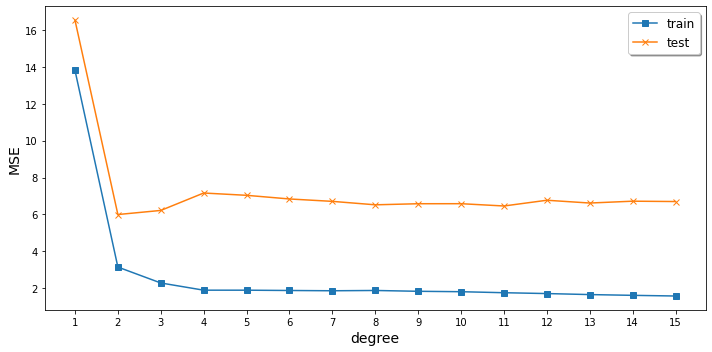

In [40]:
# 畫出各項次特徵訓練結果的 MSE
plot_mse_vs_degree(degrees, train_record, test_record)

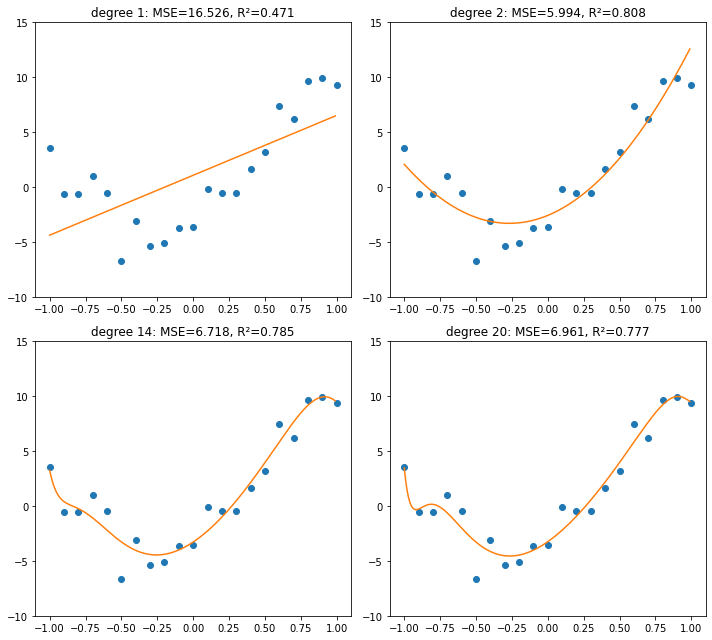

In [41]:
# 畫出訓練結果的預測函數模型
plot_fitted_function(X_train, Y_train, X_test, test_record)

<a id="references"></a>

## References:

- [1]. Kevin P. Murphy. "*Probabilistic Machine Learning: An introduction*". MIT press, 2021. [[link]](https://probml.github.io/pml-book/book1.html)
- [2]. Eli Stevens, Luca Antiga, and Thomas Viehmann. "*Deep Learning with PyTorch*". Manning Publications Co, 2020. [[link]](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf)
- [3]. Aston Zhang, Zachary Lipton, Mu Li, and Alexander Smola. "*動手學深度學習（PyTorch版）*", 2020. [[link]](https://tangshusen.me/Dive-into-DL-PyTorch)
- [4]. PyTorch Documentation [[link]](https://pytorch.org/docs/)


---

**May, 2021**

***James Chang***